# PyTorch Workflow

In [ ]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

## 1. Data (preparing and loading)

Data can be almost anything in ML
* Excel spreadsheet
* Images of any kind
* Videos
* Audios
* DNA
* Text


Machine learning is a game of 2 parts:
1. Get data into numerical representation.
2. Build model to learn patterns in that numerical representation.

y = a + bx
weight = b, bias = a

In [ ]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end= 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

### Splitting data into training and test data

In [ ]:
# Create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:

    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})

In [ ]:
plot_predictions()

## 2. Build Model

What our model does:
* Start with random values(weights & bias)
* Look at training data and adjust random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)


How does it do so?
Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [ ]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,         # <- start with random weights
                                            requires_grad=True,
                                            dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1,    # <- start with random bias
                                         requires_grad=True,
                                         dtype=torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor:  # <- "x" is the input data
    return self.weights * x + self.bias  # <- this is the linear regression formula (y = m*x + b)

### PyTorch model building essentials

* torch.nn - contains all of the building blocks for computational graphs (a neural network can be considered a computational graph)

* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us

* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()

* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent

* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in forward computation

### Checking the contents of our PyTorch Model
Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.parameters()`

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create instance of model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

In [ ]:
# List named parameters
model_0.state_dict()

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through `forward()` method.

In [ ]:
X_test, y_test

In [ ]:
y_preds = model_0(X_test)
y_preds

In [ ]:
# Make prediction with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train Model

The idea for a model to move from some *unknown* parameters (these may be random) to some known parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models prediction are is to use a loss function

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function.

  * Inside the optimizer you'll often have to set two parameters:
    * `params` - the model parameters you'd like to optimize
    * lr (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small lr results in small changes, a large lr results in large changes)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [ ]:
list(model_0.parameters())

In [ ]:
# A parameter is a value that the model sets itself
model_0.state_dict()

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate = possibly the most important hyperparameter you can set


**Q:** Which loss func and optimizer should I use?

**A:** Problem specific.

For regression, nn.L1Loss() and torch.optim.SGD()

For classfication, nn.BCELoss()

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

0. Loop through the data and do...
1. Forward pass (this involves data moving through model's `forward()` functions) to make predictions on data - also called forward propagation.
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of model with respect to the loss. (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [ ]:
torch.manual_seed(42)
# An epoch is one loop  through the data... (this is a hyperparameter because we've set it)

epochs = 200


# Tracking different values
epoch_count = []
loss_values = []
test_loss_values = []


### Training

# 0.Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward Pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()


  ## Testing
  model_0.eval() # turns off different settings in model not needed for testing

  with torch.inference_mode(): # turns off gradient tracking

    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model_0.state_dict())



In [ ]:
# Plot the loss curves
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [ ]:
model_0.state_dict()

In [ ]:
weight, bias

In [ ]:
plot_predictions(predictions=y_preds)

In [ ]:
plot_predictions(predictions=y_preds_new)

### Saving a model in PyTorch

There are 3 main methods for saving and loading models in PyTorch.

1. `torch.save()` - save PyTorch object in Python's pickle format
2. `torch.load()` - load saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary

In [ ]:
# Saving our PyTorch Model
from pathlib import Path

# 1. Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

### Loading a PyTorch Model
Since we saved our model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [ ]:
model_0.state_dict()

In [ ]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load saved state_dict
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

In [ ]:
loaded_model_0.state_dict()

In [ ]:
# Make predictions on loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

In [ ]:
# Compare preds
y_preds_new == loaded_model_preds

## 6. Putting it all together


In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import nn

torch.__version__

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it(for potentially faster computing).

If no GPU is available, code will default to CPU.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device
# !nvidia-smi

### 6.1 Data

In [ ]:
# Create some data
weight = 0.7
bias = 0.3

# Range values
start = 0
end = 1
step = 0.02

# Create X and y
X = torch.arange(start, end ,step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

In [ ]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:

    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear Model

In [ ]:
# Create  a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    # Use nn.Linear() for creating the model parameters / also called linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

In [ ]:
next(model_1.parameters()).device

In [ ]:
model_1.to(device)
next(model_1.parameters()).device

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop


In [ ]:
# Loss function
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params= model_1.parameters(),
                            lr=0.01)

In [ ]:
# Training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for our data)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_pred = model_1(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

In [ ]:
model_1.state_dict()

### 6.4 Making and evaluating predictions

In [46]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

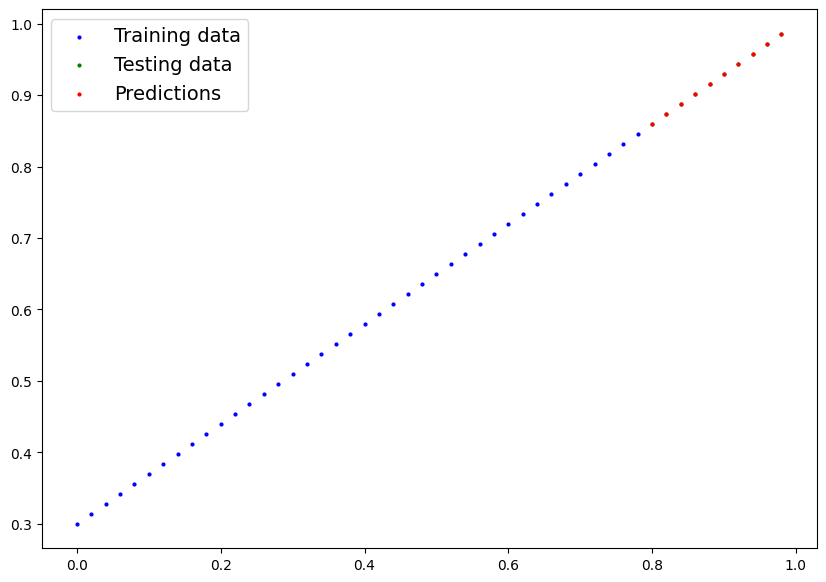

In [47]:
# Check pred visually
plot_predictions(predictions=y_preds)

### 6.5 Saving and loading a trained model

In [53]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

In [54]:
# Load a PyTorch model

loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [55]:
next(loaded_model_1.parameters()).device

device(type='cpu')

In [56]:
# Evaluate loaded model
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])